# 신호등과 차량 데이터 간의 관계 분석
- 가지고 있는 데이터(공공데이터는 모두 읍면동 단위까지 커버 가능)
    - 정상 시 평균 속도 (km/h) : 혼잡하지 않을 때의 모든 차량 평균 속도
    - 혼잡시 평균 속도 (km/h) : 혼잡할 때의 모든 차랑 평균 속도
    - 평균 속도 (km/h) : 모든 차량 평균 속도
    - 추정 교통량 (대/일) : 교통량이 관측된 데이터로 관측되지 않은 도로의 교통량을 추정
    - 혼잡 빈도 강도 (%) : 모든 차량 대비 혼잡을 경험한 차량의 대수 비율
    - 혼잡 시간 강도 (%) : 모든 차량 대비 혼잡을 경험한 차량의 주행 시간 비율
    - 신호등 구추가.csv : 신호등 위치를 구 별로 분류(분류 되지 않은 신호등도 일부 있음)
   <br/><br/>
- 분석 방향
    - 구 별로 신호등 개수 카운팅
    - 공공데이터들도 구 별로 평균
    - 각 컬럼값 별로 상관관계 히트맵 그리기


## 데이터 전처리

### 구 별로 분류해서 평균 내기

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import Lasso

In [2]:
url1 = './data/정상시평균속도.csv'
df1 = pd.read_csv(url1)

url2 = './data/혼잡시 평균속도.csv'
df2 = pd.read_csv(url2)

url3 = './data/평균속도.csv'
df3 = pd.read_csv(url3)

url4 = './data/추정교통량.csv'
df4 = pd.read_csv(url4)

url5 = './data/혼잡빈도강도.csv'
df5 = pd.read_csv(url5)

url6 = './data/혼잡시간 강도.csv'
df6 = pd.read_csv(url6)

url7 = './data/신호등 및 CCTV/신호등 구추가.csv'
df7 = pd.read_csv(url7)

In [3]:
type(df1['sigungu_code'].iloc[0])

numpy.int64

In [4]:
# 서울시 내 행정구 코드
seoul_gu_list = [11230, 11250, 11160, 11090, 11210, 11050, 11170, 11180, 11110,
                 11060, 11100, 11200, 11140, 11130, 11040, 11080, 11220,
                 11240, 11190, 11030, 11150, 11120, 11010, 11020, 11070]

# 구 이름은 구 코드를 오름차순 정렬한 순서임!!!!
seoul_gu_name = ['종로구','중구','용산구', '성동구', '광진구', '동대문구', '중랑구', '성북구', '강북구', '도봉구', 
                 '노원구', '은평구', '서대문구', '마포구', '양천구', '강서구', '구로구', '금천구', '영등포구', 
                 '동작구', '관악구', '서초구', '강남구', '송파구', '강동구']

print(len(seoul_gu_list))
print(len(seoul_gu_name))

25
25


In [5]:
# 서울시 데이터만 발라내기 / 시군구 코드로 정렬까지
for i in range(1,7):
    tempt_df = eval('df'+str(i))
    globals()['seoul_df'+str(i)] = tempt_df[tempt_df['sigungu_code'].isin(seoul_gu_list)].sort_values('sigungu_code')


In [6]:
for i in range(1, 7):
    tempt_df = eval('seoul_df'+str(i))
    print(tempt_df['sigungu_code'].unique(),'\n')
    

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 

[11010 11020 11030 11040 11050 11060 11070 11080 11090 11100 11110 11120
 11130 11140 11150 11160 11170 11180 11190 11200 11210 11220 11230 11240
 11250] 



### 공공 데이터 통합

In [7]:
traffic_df = pd.DataFrame() # 교툥 관련된 컬럼들만 모아놓을 데이터 프레임

for i in range(1,7):
    if i !=4 : # 추정 교통량은 원하는 컬럼이 마지막에 없음
        # 변수명을 변경해가며 임시 df에 저장
        tempt_df = eval('seoul_df'+str(i)).groupby('sigungu_code').mean() 
        tempt_series = tempt_df.iloc[:, -1]
    else :
        tempt_df = df4.groupby('sigungu_code').mean()
        tempt_series = tempt_df['ALL_AADT']
        
    traffic_df[tempt_series.name] = tempt_series

traffic_df

,velocity_AVRG_NRMLT,velocity_CG_AVRG,velocity_AVRG,ALL_AADT,FRIN_CG,TI_CG
sigungu_code,,,,,,
11010,42.815000,15.644375,23.564375,11562.187500,58.366250,75.490000
11020,41.336000,13.456000,22.464000,12658.000000,46.466667,72.346667
11030,45.593125,16.425000,26.289375,16315.187500,46.734375,65.851875
11040,47.555294,16.974706,25.880000,15135.117647,45.878824,68.308235
11050,54.945333,19.536667,26.521333,15905.466667,68.394667,81.948000
11060,44.081429,15.650000,24.170714,11874.785714,46.582857,67.163571
11070,46.613750,17.738125,25.180625,11027.875000,61.058750,77.847500
11080,40.892500,16.120000,23.634500,10847.200000,51.879500,72.170000
11090,40.128462,14.650000,22.142308,9538.769231,49.043077,70.274615


In [8]:
# 컬럼 이름을 보기 쉽게 변경
new_col = ['noral_speed', 'jam_speed', 'mean_speed', 'volume', 'jam_frequency', 'jam_time']
traffic_df.columns = new_col

# 구 이름 추가
traffic_df['gu_name'] = seoul_gu_name
traffic_df

,noral_speed,jam_speed,mean_speed,volume,jam_frequency,jam_time,gu_name
sigungu_code,,,,,,,
11010,42.815000,15.644375,23.564375,11562.187500,58.366250,75.490000,종로구
11020,41.336000,13.456000,22.464000,12658.000000,46.466667,72.346667,중구
11030,45.593125,16.425000,26.289375,16315.187500,46.734375,65.851875,용산구
11040,47.555294,16.974706,25.880000,15135.117647,45.878824,68.308235,성동구
11050,54.945333,19.536667,26.521333,15905.466667,68.394667,81.948000,광진구
11060,44.081429,15.650000,24.170714,11874.785714,46.582857,67.163571,동대문구
11070,46.613750,17.738125,25.180625,11027.875000,61.058750,77.847500,중랑구
11080,40.892500,16.120000,23.634500,10847.200000,51.879500,72.170000,성북구
11090,40.128462,14.650000,22.142308,9538.769231,49.043077,70.274615,강북구


### 신호등
- 단순히 구 개수가 중요하기 때문에 여기서 필요한 값은 '구' 컬럼 뿐임

In [9]:
tl_df = df7 # 원본 df 보존
tl_group_df = tl_df.groupby('구').size()

In [10]:
gu_tl_num = tl_group_df[seoul_gu_name].sort_index()
gu_tl_num

구
강남구     324
강동구     260
강북구     178
강서구     453
관악구     328
광진구     147
구로구     388
금천구     198
노원구     292
도봉구      86
동대문구    374
동작구     215
마포구     371
서대문구    271
서초구     308
성동구     184
성북구     373
송파구     435
양천구     199
영등포구    309
용산구     287
은평구     264
종로구     270
중구      274
중랑구     366
dtype: int64

In [11]:
# 통합 데이터 프레임에 추가
traffic_df = traffic_df.sort_values('gu_name')
traffic_df['traffic_light_num'] = gu_tl_num.values
traffic_df

,noral_speed,jam_speed,mean_speed,volume,jam_frequency,jam_time,gu_name,traffic_light_num
sigungu_code,,,,,,,,
11230,46.885455,16.068636,25.252273,16200.409091,52.389091,73.929091,강남구,324
11250,45.620556,17.652778,26.592778,12864.111111,52.006667,69.035556,강동구,260
11090,40.128462,14.650000,22.142308,9538.769231,49.043077,70.274615,강북구,178
11160,47.523000,16.595500,25.255000,12690.150000,51.088000,68.789000,강서구,453
11210,44.387143,15.189524,24.623333,11969.333333,36.587143,60.405238,관악구,328
11050,54.945333,19.536667,26.521333,15905.466667,68.394667,81.948000,광진구,147
11170,43.056000,15.010667,22.927333,10829.133333,50.253333,69.771333,구로구,388
11180,44.692000,16.138000,23.442000,12296.700000,55.150000,72.415000,금천구,198
11110,43.812105,16.684737,23.406316,11107.421053,56.855789,73.567895,노원구,292


## 상관 관계 분석

In [19]:
traffic_df.corr()

,noral_speed,jam_speed,mean_speed,volume,jam_frequency,jam_time,traffic_light_num
noral_speed,1.000000,0.851823,0.743871,0.684300,0.502946,0.430738,0.158140
jam_speed,0.851823,1.000000,0.683693,0.418668,0.657141,0.532939,0.118160
mean_speed,0.743871,0.683693,1.000000,0.748945,0.018606,-0.076495,0.242516
volume,0.684300,0.418668,0.748945,1.000000,0.010898,0.017970,0.104286
jam_frequency,0.502946,0.657141,0.018606,0.010898,1.000000,0.967065,0.053653
jam_time,0.430738,0.532939,-0.076495,0.017970,0.967065,1.000000,0.005808
traffic_light_num,0.158140,0.118160,0.242516,0.104286,0.053653,0.005808,1.000000


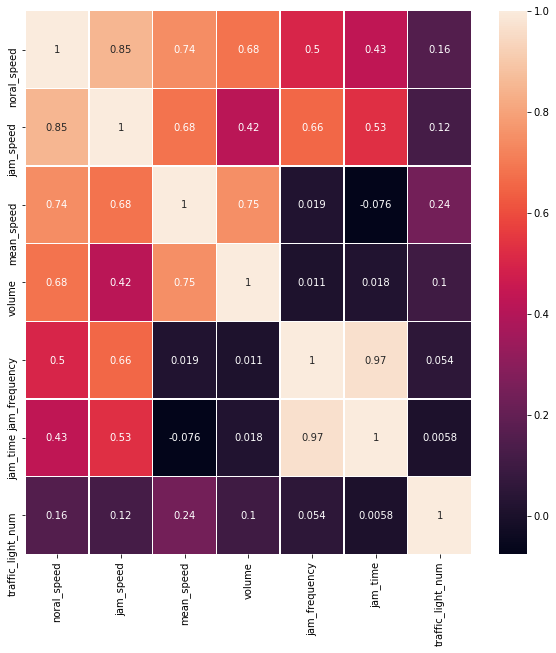

In [25]:
plt.figure(figsize=(10,10))

sns.heatmap(traffic_df.corr(), annot=True, linewidths=.5)

plt.show()